# 応用コンテンツ

## XAI
* SHAP
    * [SHAPで機械学習モデルを解釈してみた](https://tech.datafluct.com/entry/20220223/1645624741)
    → そのモデルで推論した際、「なぜこの結果を算出したか」の示唆を与えてくれる

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

"""
Medlnc	世帯所得の中央値
HouseAge	住宅の築年数
AveRooms	住宅の部屋数の平均
AveBedrms	住宅の寝室数の平均
Poplation	居住人数の合計
AveOcuup	世帯人数の平均
Latitude	各地区における代表地区の緯度
Longitude	各地区における代表地区の軽度
y: 住宅価格
"""
dataset = fetch_california_housing()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = dataset.target
display(X.head())
display(y)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [3]:
# モデル構築
## SHAPの場合、推論するわけではないので全データで学習してもよいが、その値の信頼性を確認するためにもtrain, testで分割して精度を見ておいたほうがよい
## (精度が著しく低いモデルでの特徴量の影響度合いを見ても意味がないため。本サンプルでは一旦全体で学習させる)
### もう少し実務的に実施する場合はhttps://qiita.com/perico_v1/items/fbbb18681ecc362a4f9e　を参照
## SHAPでは実際の値で比較できたほうがわかりやすいため、木構造モデルを採用することが多い
### 標準化が必要なモデルでは戻す処理が必要なため
import xgboost
model = xgboost.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [4]:
# SHAPの計算
import shap

# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

# 2. 説明変数(特徴量)を渡し、shapの結果を受け取る
shap_values = explainer(X)

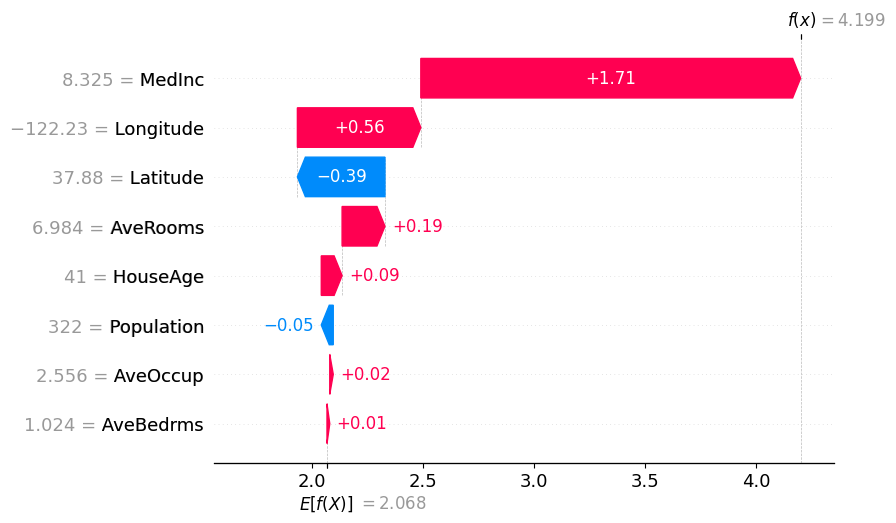

In [5]:
# waterfall
shap.plots.waterfall(shap_values[0])  # 1番目のデータを描画
# 影響している特徴量はMedInc, Longitude
# 全体平均は2.068だが、この0番目データでは4.199と予測。その影響として、MedIncが+1.71押し上げている。Longitudeが0.56押し上げている。
# Latitudeが-0.39押し下げている。
# ただし個々のデータの推論結果とその特徴量の値を細かく見ることは稀。次に示すbeeswarmを全体傾向として利用することが多い。

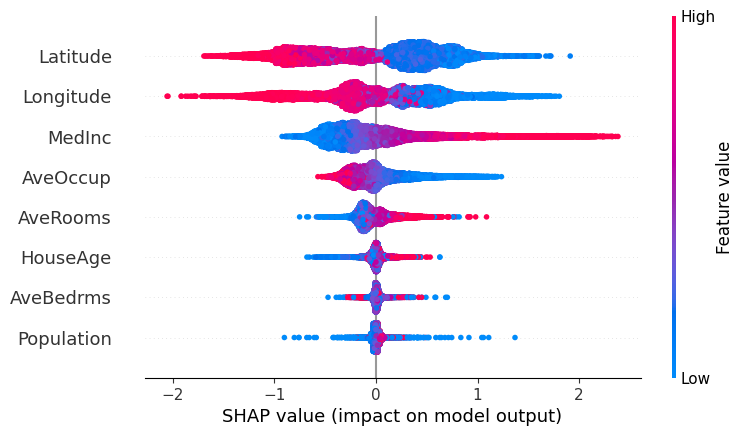

In [6]:
# beeswarm: 最もよく利用する
## 横軸はSHAP Value, いわゆる影響度の大きさ
## 縦軸は特徴量
## 1. SHAP Valueが広い値を取る特徴量が影響力が大きい
## 2. 各特徴量の値の赤はその特徴量自体の値が大きいか小さいか。Latitude/Longitudeは、SHAP Valueが負の方向に値が大きいことがわかる。
## 3. MedInc(収入)が高いほど目的変数（住宅価格）への影響度(値の大きさ)も強い
## 4. Latitude(緯度)が低いほど目的変数（住宅価格）への影響度(値の大きさ)も強い → 南のほうが目的変数の値が高い
shap.plots.beeswarm(shap_values)

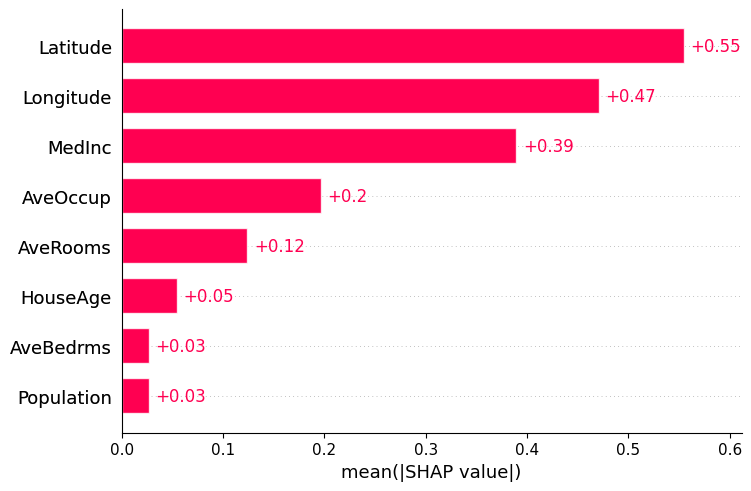

In [7]:
# 上記の絶対値
shap.plots.bar(shap_values)

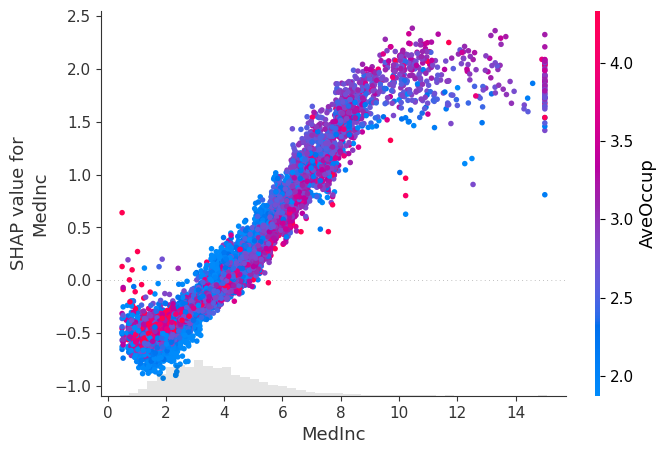

In [8]:
# 収入とSHAP Value
## 相互作用も確認できるようになっている。
## color引数にshap値の変数を指定すると、自動的に適した変数が選択される
## 今回はAveOccupが選ばれていて、AveOccupの大小によって、同じMedIncでもAveOccupの値の傾向が異なることが確認できる
shap.plots.scatter(shap_values[:, 'MedInc'], color=shap_values)

## DiCE
* SHAPと同様に特徴量の影響度合いを測ることができる
* 特に反実仮想(例: キャンペーンを送付したがもし送付されていない場合)を考慮して「この特徴量の値が±αだったら成約する」という値を求めることができる.
* ただし元のモデル精度に依存するため注意が必要
* 利用例: ローン貸出審査(現在貸出できないが、もしこのパラメータが...だったら貸し出せるようになる), 営業員ランク(現在ランクAだが、このパラメータを上げればBになる)
* 参考サイト: https://speakerdeck.com/daikikatsuragawa/ji-jie-xue-xi-niokerufan-shi-jia-xiang-shuo-ming-wosheng-cheng-sururaiburari-dice?slide=5

In [2]:
!pip install dice_ml
# 以下、一部エラーとなるがgoogle colaboratoryでは無視して問題なし。conda等の仮想環境構築時は注意が必要.

In [11]:
import seaborn as sns
import pandas as pd

# titanicのデータを読み込みnull値等の最低限チェック
titanic_df = sns.load_dataset('titanic')
display(titanic_df.head())
null_columns = titanic_df.columns[titanic_df.isnull().any()].tolist()
null_counts = titanic_df[null_columns].isnull().sum()
display(null_counts)
display(titanic_df.describe())

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


,0
age,177
embarked,2
deck,688
embark_town,2


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
#nullを含むカテゴリ値
targets = ["embarked", "deck", "embark_town"]
for target in targets:
    display(titanic_df[target].value_counts())

,embarked
S,644
C,168
Q,77


,deck
C,59
B,47
D,33
E,32
A,15
F,13
G,4


,embark_town
Southampton,644
Cherbourg,168
Queenstown,77


In [13]:
titanic_df = titanic_df.drop(columns="alive")

# 欠損値への対応
titanic_df["age"] = titanic_df.groupby("class")["age"].transform(lambda x: x.fillna(x.median()))
titanic_df["embarked"] = titanic_df.groupby("class")["embarked"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))
titanic_df["deck"] = titanic_df.groupby("class")["deck"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))
titanic_df["embark_town"] = titanic_df.groupby("class")["embark_town"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))

# label encoding(木構造向け)
titanic_df["sex"], _ = pd.factorize(titanic_df["sex"], sort=True)
titanic_df["embarked"], _ = pd.factorize(titanic_df["embarked"], sort=True)
titanic_df["class"], _ = pd.factorize(titanic_df["class"], sort=True)
titanic_df["who"], _ = pd.factorize(titanic_df["who"], sort=True)
titanic_df["adult_male"], _ = pd.factorize(titanic_df["adult_male"], sort=True)
titanic_df["deck"], _ = pd.factorize(titanic_df["deck"], sort=True)
titanic_df["embark_town"], _ = pd.factorize(titanic_df["embark_town"], sort=True)
titanic_df["alone"], _ = pd.factorize(titanic_df["alone"], sort=True)

In [14]:
titanic_df.describe()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.066409,0.523008,0.381594,32.204208,1.536476,1.308642,1.210999,0.602694,4.262626,1.536476,0.602694
std,0.486592,0.836071,0.477990,13.244532,1.102743,0.806057,49.693429,0.791503,0.836071,0.594291,0.489615,1.386348,0.791503,0.489615
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,1.000000,1.000000,0.000000,4.000000,1.000000,0.000000
50%,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.454200,2.000000,2.000000,1.000000,1.000000,5.000000,2.000000,1.000000
75%,1.000000,3.000000,1.000000,37.000000,1.000000,0.000000,31.000000,2.000000,2.000000,2.000000,1.000000,5.000000,2.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,2.000000,2.000000,1.000000,6.000000,2.000000,1.000000


In [15]:
# モデル構築
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.ensemble import RandomForestClassifier
import dice_ml
from dice_ml import Dice

model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(titanic_df.drop(columns="survived"), titanic_df["survived"], test_size=0.2, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
# DiCEのData and Modelオブジェクトの作成
cat_features = ["pclass", "sex", "sibsp", "parch", "embarked", "class", "who", "adult_male", "deck", "embark_town", "alone"]

d = dice_ml.Data(dataframe=titanic_df, continuous_features=['age', 'fare'], categorical_features=cat_features, outcome_name='survived')
m = dice_ml.Model(model=model, backend="sklearn")

# Diceオブジェクトの作成
dice = Dice(d, m)

# 反事実の生成（例: テストデータの最初のインスタンスに対して反事実を生成）
query_instance = X_test.iloc[0:1]
display(query_instance)
features_to_vary= ["pclass", "age", "parch", "fare", "embarked", "class"] #変化を許す変数
permitted_range = {"age":[5, 80]}
dice_exp = dice.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")


,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
709,3,1,24.0,1,1,15.2458,0,2,1,1,5,0,0


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


In [17]:
# 結果を表示
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone,survived
0,3,1,24.0,1,1,15.2458,0,2,1,1,5,0,0,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone,survived
0,3,1,13.3,1,1,15.2458,0,2,1,1,5,0,0,1
1,3,0,7.0,1,1,15.2458,0,2,1,1,5,0,0,1
2,3,1,16.2,1,1,15.2458,0,2,1,1,5,0,0,1


## 実験管理(MLFlow)
* 参考サイト: https://tech.datafluct.com/entry/20220603/1654251480

In [17]:
!pip install optuna
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.0/563.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62

In [18]:
# 以下、MLFlow + Optuna（元々ローカルの.pyで実行していたコードをそのまま貼っています。そのままではファイル作成などの箇所が動かないのでコードは参考程度としてください)
import tempfile
from sklearn.linear_model import LogisticRegression
# https://tech.preferred.jp/ja/blog/hyperparameter-tuning-with-optuna-integration-lightgbm-tuner/ を用いることでLightgbmでの探索を簡素化できる
# 今回はscikit-learnのAPIを用いたため愚直に実装している
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import optuna
from abc import ABC, abstractmethod
import mlflow
import traceback

class MlflowSettings:
    """
    MLFlowの設定クラス. 本クラスでは保存領域へ実験名を設定する
    """
    def __init__(self, exp_name):
        self.experiment_name = exp_name
        self.experiment_id = None
        self.client = None

    def set_experiment(self):
        experiment_name = self.experiment_name
        self.client = mlflow.tracking.MlflowClient(tracking_uri=mlflow.get_tracking_uri())
        for exp in self.client.search_experiments():
            if experiment_name == exp.name:
                self.experiment_id = exp.experiment_id
                break
        else:
            self.experiment_id = self.client.create_experiment(experiment_name)

    def mlflow_callback(self, study, trial):
        """
        本メソッドではoptunaの学習時に呼ばれaccuracyをログに記録する
        """
        trial_value = trial.value if trial.value is not None else float("nan")
        with mlflow.start_run(experiment_id=self.experiment_id, run_name=study.study_name):
            mlflow.log_params(trial.params)
            mlflow.log_metric("accuracy", trial_value)


class BaseModel(ABC):

    def __init__(self, train_x:np.array, train_y:np.array, test_x:np.array, test_y:np.array):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.model = None
        self.scaler = StandardScaler()
        self.scaler.fit(self.train_x)
        self.accuracy = None
        self.output_importance_path = None

    @abstractmethod
    def search_best_params(self):
        pass

    @abstractmethod
    def train(self):
        pass

    def predict(self):
        pred = self.model.predict(self.test_x)
        self.accuracy = accuracy_score(self.test_y, pred)
        print(f"LGBM: Optuna average score: {self.accuracy:.3f}")

    @abstractmethod
    def evaluate(self):
        pass

    def cleanup(self):
        if not self.output_importance_path and os.path.isdir(self.output_importance_path):
            self.output_importance_path.cleanup()

    def _visualize(self, params:dict, study, output_dir:str='./image'):
        print('Hyper parameter importance:')
        search_params: list = list(params.keys())
        print(f"params:{search_params}")
        try:
            importances = optuna.importance.get_param_importances(
                study=study,
                params=search_params)
            for k, v in importances.items():
                print(f'{k}: {v}')

            # .show()をおこなうとその場で可視化する。jupyterの場合は.show()のほうも利用を検討すべき。
            fig = optuna.visualization.plot_param_importances(study)
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            fig.write_html(f'{output_dir}/param_importance.html')
            fig.write_image(f'{output_dir}/param_importance.png')
            print(f"saved: {output_dir}")
        except Exception as e:
            print(f"unexpected error occurred.{traceback.print_exc()}")

    def _create_evaluate_values(self, exp_name: str, total_name: str, saved_path: str):
        last_mlflow = MlflowSettings(f'best_params_{exp_name}')
        last_mlflow.set_experiment()
        with mlflow.start_run(experiment_id=last_mlflow.experiment_id, run_name=exp_name) as run:
            mlflow.log_params(self.best_params)
            mlflow.log_metric('accuracy', self.accuracy)
            mlflow.lightgbm.log_model(self.model, artifact_path=f'{exp_name}-model')
            mlflow.log_artifact(f"{saved_path}/param_importance.png")

            # mlflow > models への登録処理
            name = total_name
            tags = {'data': 'iris'}
            try:
                last_mlflow.client.get_registered_model(name)
            except:
                last_mlflow.client.create_registered_model(name)

            run_id = run.info.run_id
            model_uri = "runs:/{}/{}".format(run_id, total_name)
            mv = last_mlflow.client.create_model_version(name, model_uri, run_id, tags=tags)
            print("model version {} created".format(mv.version))

class OptunaLogisticRegression(BaseModel):

    def __init__(self, train_x:np.array, train_y:np.array, test_x:np.array, test_y:np.array):
        super().__init__(train_x, train_y, test_x, test_y)
        mlflow_settings = MlflowSettings('optuna_lr_sample')
        mlflow_settings.set_experiment()
        self.mlflow_settings = mlflow_settings
        self.best_params = None
        # 一時フォルダを作成しそこに格納することで余計なフォルダを自動削除する
        self.output_importance_path = tempfile.TemporaryDirectory().name
        print(f"tempdir: {self.output_importance_path}")

    def search_best_params(self):

        def objective(trial):
            """
            ハイパーパラメータの最適化を行うための「目的関数」を定義する関数
            以下のparamsにはkeyにパラメータ名, valueにはそのパラメータ名に対応した範囲を定義する。
            ”trial_suggest_”の第一引数にパラメータ名、第二引数で最小値・第三引数で最大値を指定する。詳細は公式リファレンス参照。
            """
            params = {
                'C': trial.suggest_float('C', 1e-4, 1e2),
                'max_iter': trial.suggest_int('max_iter', 500, 2000, step=100)
            }
            model = LogisticRegression(**params)
            sk = StratifiedKFold(n_splits=3)
            train_x = self.scaler.transform(self.train_x)
            # cross_val_scoreがtrain_dataを自動的に分割する. 単位はcvで設定.
            score = cross_val_score(model, train_x, self.train_y, cv=sk)
            accuracy = score.mean()

            return accuracy

        # create_study: 目的関数の最適化
        # 精度によってmaximize/minimizeを変更する.
        # RMSEなどはminimize
        study = optuna.create_study(direction='maximize', study_name='LogisticRegression')
        # n_trials: 試行回数を定義する。第一引数はobjectiveメソッドを指定する。
        study.optimize(objective, n_trials=10, callbacks=[self.mlflow_settings.mlflow_callback])
        # 探索結果はstudyに格納される。
        self.best_params = study.best_params
        print(f"study.best_params:{study.best_params}")
        print(f"study.best_value:{study.best_value}")

        # 以下でハイパーパラメータの重要度を算出できる。
        self._visualize(self.best_params, study, output_dir=self.output_importance_path)

    def train(self):
        self.model = LogisticRegression(random_state=42, **self.best_params)
        train_x = self.scaler.transform(self.train_x)
        self.model.fit(train_x, self.train_y)

    def predict(self):
       super().predict()

    def evaluate(self):
        self._create_evaluate_values('lr', 'LogisticRegression', self.output_importance_path)

class OptunaLGBMClassifier(BaseModel):

    def __init__(self, train_x:np.array, train_y:np.array, test_x:np.array, test_y:np.array):
        super().__init__(train_x, train_y, test_x, test_y)
        mlflow_settings = MlflowSettings('optuna_lgbm_sample')
        mlflow_settings.set_experiment()
        self.mlflow_settings = mlflow_settings
        self.best_params = None
        self.output_importance_path = tempfile.TemporaryDirectory().name
        print(f"tempdir: {self.output_importance_path}")

    def search_best_params(self):

        def objective(trial):
            params = {
                'num_leaves': trial.suggest_int('num_leaves', 2, 100),
                'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            }
            # verbose=-1を指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
            model = lgb.LGBMClassifier(n_estimators=10000, verbose=-1, **params)
            # デフォルトのcross_val_scoreではearly_stoppingを適用できないため簡易的に実装
            score = self._cross_val_score(model, self.train_x, self.train_y)
            accuracy = score.mean()
            return accuracy

        study = optuna.create_study(direction='maximize', study_name='LightGBMClassifier')
        # n_trials: 試行回数を定義する。第一引数はobjectiveメソッドを指定する。
        study.optimize(objective, n_trials=10, callbacks=[self.mlflow_settings.mlflow_callback])
        # 探索結果はstudyに格納される。
        self.best_params = study.best_params
        print(f"study.best_params:{study.best_params}")
        print(f"study.best_value:{study.best_value}")

        # 以下でハイパーパラメータの重要度を算出できる。
        self._visualize(self.best_params, study, output_dir=self.output_importance_path)

    def train(self):
        self.model = lgb.LGBMClassifier(random_state=42, verbose=-1, **self.best_params)
        self.model.fit(self.train_x, self.train_y)

    def predict(self):
       super().predict()

    def evaluate(self):
        self._create_evaluate_values('lgbm', 'LightGBMClassifier', self.output_importance_path)

    def _cross_val_score(self, model, X: np.array, y: np.array) -> np.array:
        acc = np.array([])
        cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
        for train_index, valid_index in cv.split(X, y):
            train_x, valid_x = X[train_index], X[valid_index]
            train_y, valid_y = y[train_index], y[valid_index]
            model.fit(train_x,
                      train_y,
                      eval_set=[(valid_x, valid_y)],
                      callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.log_evaluation(0)],
                      )
            pred_y = model.predict(valid_x)
            ac = accuracy_score(valid_y, pred_y)
            acc = np.append(acc, ac)
        return acc

def main():
    iris = load_iris()
    train_x, test_x, train_y, test_y = train_test_split(iris.data, iris.target, test_size=0.25, random_state=42, stratify=iris.target)
    lgbm_model: BaseModel = OptunaLGBMClassifier(train_x, train_y, test_x, test_y)
    logistic_model: BaseModel = OptunaLogisticRegression(train_x, train_y, test_x, test_y)
    models = [lgbm_model, logistic_model]
    for m in models:
        try:
            m.search_best_params()
            m.train()
            m.predict()
            m.evaluate()
        finally:
            m.cleanup()

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2024-10-06 10:36:20,876] A new study created in memory with name: LightGBMClassifier
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
[I 2024-10-06 10:36:20,989] Trial 0 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 3, 'min_child_weight': 0.027069634942346196, 'min_child_samples': 88}. Best is trial 0 with value: 0.33926031294452347.


tempdir: /tmp/tmpmm5vfy2x
tempdir: /tmp/tmpa123llf1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861


<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
[I 2024-10-06 10:36:21,261] Trial 1 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 86, 'min_child_weight': 0.02031209985567981, 'min_child_samples': 41}. Best is trial 0 with value: 0.33926031294452347.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023


[I 2024-10-06 10:36:21,459] Trial 2 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 37, 'min_child_weight': 0.0266854239585698, 'min_child_samples': 100}. Best is trial 0 with value: 0.33926031294452347.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
[I 2024-10-06 10:36:21,586] Trial 3 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 95, 'min_child_weight': 0.08259046061586972, 'min_child_samples': 58}. Best is trial 0 with value: 0.33926031294452347.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861


<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
[I 2024-10-06 10:36:21,774] Trial 4 finished with value: 0.9376481744902798 and parameters: {'num_leaves': 71, 'min_child_weight': 0.02054637836548161, 'min_child_samples': 18}. Best is trial 4 with value: 0.9376481744902798.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.163125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.0868412
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.188968
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915


[I 2024-10-06 10:36:21,923] Trial 5 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 27, 'min_child_weight': 0.03604775506237788, 'min_child_samples': 99}. Best is trial 4 with value: 0.9376481744902798.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861


[I 2024-10-06 10:36:22,095] Trial 6 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 97, 'min_child_weight': 0.003424789841321129, 'min_child_samples': 67}. Best is trial 4 with value: 0.9376481744902798.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),
[I 2024-10-06 10:36:22,313] Trial 7 finished with value: 0.8847795163584639 and parameters: {'num_leaves': 23, 'min_child_weight': 0.045477942304586357, 'min_child_samples': 36}. Best is trial 4 with value: 0.9376481744902798.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight'

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.682655
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.223526
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.148751
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915


[I 2024-10-06 10:36:22,493] Trial 8 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 79, 'min_child_weight': 0.0028213831327921547, 'min_child_samples': 68}. Best is trial 4 with value: 0.9376481744902798.
<ipython-input-18-f6e59e7fc260>:199: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 0.1),


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.10023


[I 2024-10-06 10:36:22,622] Trial 9 finished with value: 0.33926031294452347 and parameters: {'num_leaves': 63, 'min_child_weight': 0.04217295498652586, 'min_child_samples': 43}. Best is trial 4 with value: 0.9376481744902798.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.09861
study.best_params:{'num_leaves': 71, 'min_child_weight': 0.02054637836548161, 'min_child_samples': 18}
study.best_value:0.9376481744902798
Hyper parameter importance:
params:['num_leaves', 'min_child_weight', 'min_child_samples']
min_child_samples: 0.8640846251434685
num_leaves: 0.08488083428338976
min_child_weight: 0.05103454057314174


Traceback (most recent call last):
  File "<ipython-input-18-f6e59e7fc260>", line 98, in _visualize
    fig.write_image(f'{output_dir}/param_importance.png')
  File "/usr/local/lib/python3.10/dist-packages/plotly/basedatatypes.py", line 3835, in write_image
    return pio.write_image(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/plotly/io/_kaleido.py", line 266, in write_image
    img_data = to_image(
  File "/usr/local/lib/python3.10/dist-packages/plotly/io/_kaleido.py", line 132, in to_image
    raise ValueError(
ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



unexpected error occurred.None
LGBM: Optuna average score: 0.842


2024/10/06 10:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpmm5vfy2x/param_importance.png'

## 複数のモデルの一括実行(pyCaret)
* 参考サイト: https://tech.datafluct.com/entry/20220727/1658915220

In [ ]:
!pip install autoviz
!pip install pycaret

In [ ]:
import pycaret
print(pycaret.__version__)
from pycaret.datasets import get_data
from pycaret.regression import setup, compare_models, tune_model, create_model, plot_model, evaluate_model
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 保険料はいくらになるかの過去データ
data = get_data("insurance")
reg1 = setup(data, target="charges", session_id=1)

# MODEL
best_model = compare_models(exclude=["lightgbm"])

In [ ]:
# k分割交差検証(k-fold cross validation)
best_model = compare_models(exclude=["lightgbm"], fold=5)

In [ ]:
gbr = create_model("gbr")
print(gbr)

In [ ]:
# best modelをハイパラ設定
tuned_best_model = tune_model(gbr, n_iter=20, optimize="RMSE")

In [ ]:
# モデルの要因探索
Exploratory_analysis = evaluate_model(tuned_best_model)

In [ ]:
# 参考: ハイパラチューニングは効果がなかったが、可視化する際は以下。
plot_model(tuned_best_model)
# 縦軸: 残差, 横軸: 予測値 を表す。可視化結果

# EDA(pyGWalker, SweetViz, Autoviz,  Streamlit)

In [ ]:
!pip install pygwalker sweetviz autoviz streamlit

## ハイパーパラメーター最適化: Optuna

# 大規模データ処理: Polars, Ibis

## 単語の応用: networkx関係